In [1]:
import os 
import pandas as pd
import numpy as np
import subprocess
import sys
import shutil
from distutils.dir_util import copy_tree
import distutils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib notebook

# load up dependencies and functions, Note pyGSSHA_functions.py and  GSSHA.exe MUST be in kernal's working dir
%run pyGSSHA_functions.py

### Specify the rainfall date_range 
Notes: 


- PrjName   =  the project name under which the WMS file is saved
- Input_Precip_df - A dataframe of timerseries precipitation data Note that this has to be in memory INSIDE of the current - script
- Precip_column_Name - The column in the above Input_Precip_df to use
- StartDate - Desired start date of the run (note will work if no hours or minutes but best to add them)
- EndDate  - Desired end date of the run 
- Lat lon of the gauge site, important for GSSHA calculations  (Needs to be formatted as string) 
- RainSeries_timestep_Mins - The timestep of the input rainfall data from Input_Precip_df

Autovariables, can be added if needed 
- PrjDir= os.path.join('.', 'RUN')    = can be specified if its not in a RUN subdirectory of the pwd
- ImpPrecip_units="Inches" - Units of the precip df, this converts it to mm before running in GSSHA as mm is the default GSSHA units
- GageName="mooface" - name of gauge, not so important

### Create/ read in some in-memory dataframes that the functions will use

In [2]:
# There needs to be a cell in here that reads in a rainfall file into memory, 
Input_Precip_File = os.path.join("..", "input_data", "OBS_data_rain_Streams_2007-2021.csv")
Input_Precip_df = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 

# while we are at it read in the streamflow data too
Input_Stream_df = pd.read_csv(os.path.join(".", "data", 'WailukuFlow.csv'))#.set_index('datetime')
Input_Stream_df['datetime'] = pd.to_datetime(Input_Stream_df['datetime'], errors='coerce')
Input_Stream_df.set_index('datetime', inplace=True)
StreamFlow_column_Name = 'WailukuFlow'

# and also make a dataframe of the biggest events to use while iterating
biguns = Biguns_large_event_finder(Input_Stream_df, StreamFlow_column_Name, num_top_events = 10, resample_timestep='1D')

### Parameters for gag and other files

In [3]:
PrjName = 'Iao_v2_Soils_inflf_100m'
Input_Precip_df = Input_Precip_df
Precip_column_Name = "rain_in"
# Event Variables 
StartDate   =  "2018-02-17 00:00"
EndDate     =    "2018-02-21 00:00"
RainSeries_timestep_Mins = 30
Lat  = "753250.0"      # For Waihehe 753354,    # For WaiehuKou,"758000.0"    # for Iao 753250
Lon  = "2310140.0"      # For Waihehe 2314472,   # For WaiehuKou,"2315555.0"   # for Iao 2310140
RUN_dir = os.path.join('.', 'RUN')

### Parameters for .CMT file 

In [4]:
#Step 1)  Need to specify in this list each of the codes used in WMS that are for parameters and dont contain actual values  
Code_list_in_WMS = [
    "-251",
    "-252",
    "-253",
    "-254",
    "-255",
    "-256",
    "-257",
    "-2211",
    "-2212",
    "-2213",
    "-2214",
    "-2215",
    "-2216",
    "-2217",
    "-107",
    "-108",
    "-1014",
    "-1015",
    "-1016",
    "-1017",
    "-1021",
    "-1022", 
    "-351",  
    "-3211"]

# Step 2) Read in frame of base values for all other parameter codes not explicitly modified by the above cell 
Code_Key_df = pd.read_csv(os.path.join('.', 'data', 'Parameter_Codes.csv')) 

# Step 3 define CMT Parameters to Iterate over 
Param_1_code = "-251"                             # For each need to define the code and 
Param_1_name = "HYDR_COND_251"
HYDR_COND_251 = equal_spacing(0.1, 100, 5)   # The range of values to sub-in 

Param_2_code =  "-2211"  
Param_2_name =  "HYDR_COND_2211"
HYDR_COND_2211 = log_spacing(-1, 2, 5)

# Note that it is possible to iterate over individual paramaters in isolation, or change multiple ones each iteration 


#### Iterate over one cmt paraater at a time 

 Things that need manual changing are marked as #******

Simulation time is 5790 minutes
number of time rows is 193
The NSE is -0.08909704817809438


<IPython.core.display.Javascript object>


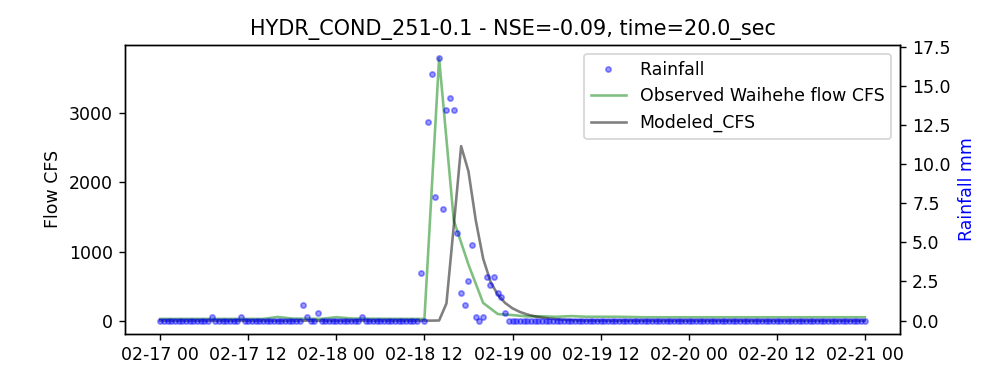

Simulation time is 5790 minutes
number of time rows is 193
The NSE is -0.09486088461474518


<IPython.core.display.Javascript object>


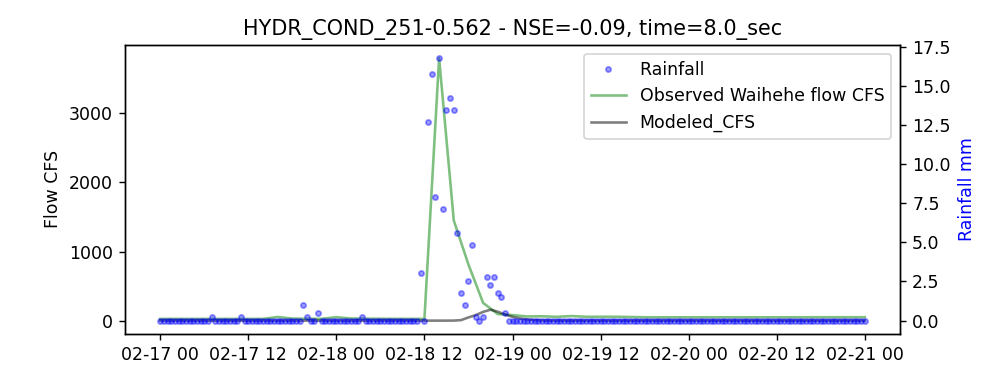

Simulation time is 5790 minutes
number of time rows is 193
The NSE is -0.10523857769640288


<IPython.core.display.Javascript object>


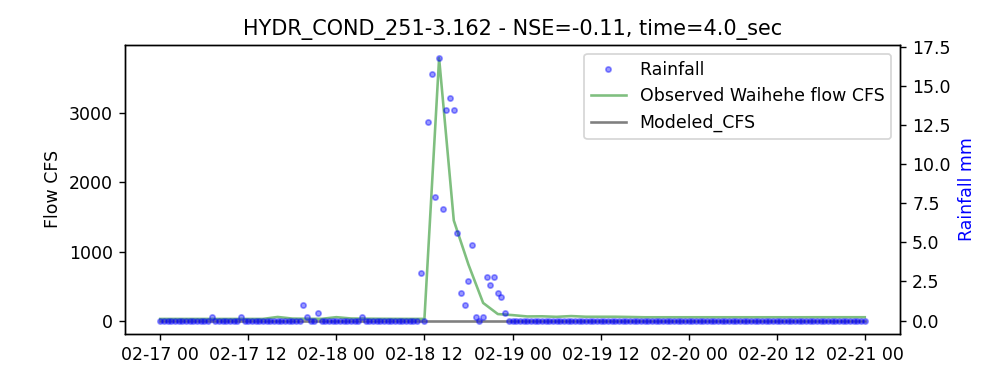

Simulation time is 5790 minutes
number of time rows is 193
The NSE is -0.10523857769640288


<IPython.core.display.Javascript object>


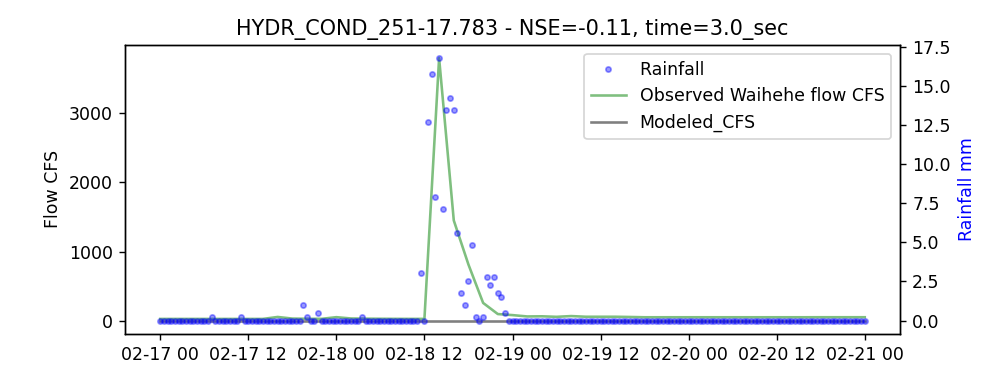

Simulation time is 5790 minutes
number of time rows is 193
The NSE is -0.10523857769640288


<IPython.core.display.Javascript object>


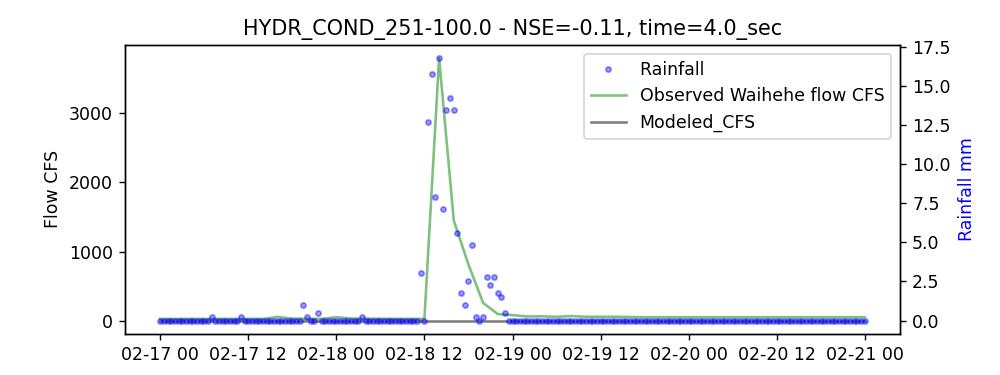

In [5]:
# Ready to Iterate over one cmt parameter 

run_list = HYDR_COND_2211      #******

for value in run_list:
    # This is critical for each run that have a cmt file with 000000 parameters, as it removed them
    refresh_model(PrjName)    # Nuke out the RUN directory to start fresh
    
    # for accounting which run is happening 
    param_code = Param_2_code   #******
    param_name = Param_2_name   #******
    param_val  = value
    
    # Set the parameters in the cmt file
    cmt_prama_jama(param_code, param_val, PrjName)   # Set the parameter(s) for the run
    assign_cmt_base_vals(Code_Key_df, Code_list_in_WMS, PrjName)  # Use the dataframe and list of parameters above to assign the base values to all 
    
    
    # Rewrite Gag file and make run length the same as the file 
    Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                       Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                       Lat, Lon, RainSeries_timestep_Mins)
    
    # use unique start date to create streamflow obs file 
    SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)
    
##### RUN GSSHA    ######
    elapsed = run_GSSHA(PrjName, RUN_dir)

    # Postprocessing and plotting 
    OutHydro = process_otl_file(StartDate, PrjName)   # Process output hydrograph
    RunID = "{}-{}".format(str(Param_1_name), str(param_val))
    Plot_and_Compare(OutHydro, SlicedStreamflow_df, Rain_Data_Frame, RunID, elapsed)


In [109]:
biguns

,datetime,WailukuFlow
0,2004-03-22,1700.270833
1,2004-01-03,1142.520833
2,2021-03-17,1085.776224
3,2004-04-10,915.552083
4,2015-04-27,908.032847
5,2021-04-05,843.261649
6,2005-03-29,840.791667
7,2014-03-22,840.179487
8,2016-12-31,825.333333
9,2014-03-15,810.764706


In [110]:
Input_Precip_df

,rain_in,WaiheheFlow,Wailuku_KepaniwaiFlow
datetime,,,
2007-10-02 00:00:00,0.0,150.00,556.000000
2007-10-02 00:30:00,0.0,132.00,509.000000
2007-10-02 01:00:00,0.0,111.50,442.000000
2007-10-02 01:30:00,0.0,99.05,396.000000
2007-10-02 02:00:00,0.0,87.80,373.000000
...,...,...,...
2022-01-30 21:30:00,0.0,53.70,15.233333
2022-01-30 22:00:00,0.0,53.70,15.100000
2022-01-30 22:30:00,0.0,53.70,15.233333
